In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')
sys.path.append('.')

from src.utils.data_utils import get_cifar_data
from src.main.main import run_single_experiment
from inspect import signature

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Using TensorFlow backend.


## Use CIFAR-10 image data for experiments

In [2]:
(x_train, y_train), (x_test, y_test) = get_cifar_data()

## Examine a few sampels of the data

<Figure size 432x288 with 0 Axes>

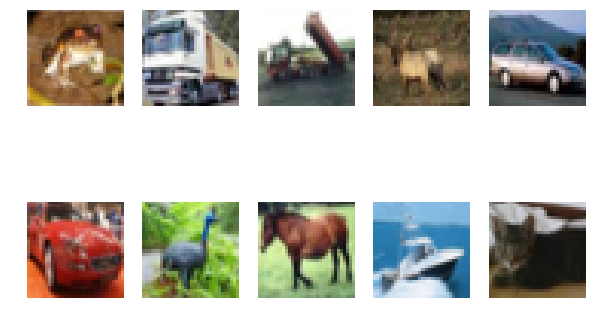

In [3]:
n_samples=10
plt.figure()
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(x_train[i,:])
    ax.axis('off')
plt.show()

## Set our experimental parameters

In [4]:
data_samples = None
monte_carlo_samples = 25

In [5]:
y_true, prediction_df, stochastic_predictions, Yt_hat = run_single_experiment(data_samples,
                                                                     monte_carlo_samples)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 76s 2ms/step - loss: 1.6348 - acc: 0.4242 - val_loss: 1.5935 - val_acc: 0.4608
Epoch 2/20
45000/45000 [==============================] - 62s 1ms/step - loss: 1.2823 - acc: 0.5476 - val_loss: 1.1356 - val_acc: 0.5974
Epoch 3/20
45000/45000 [==============================] - 60s 1ms/step - loss: 1.1688 - acc: 0.5851 - val_loss: 1.0421 - val_acc: 0.6334
Epoch 4/20
45000/45000 [==============================] - 69s 2ms/step - loss: 1.1069 - acc: 0.6060 - val_loss: 1.0092 - val_acc: 0.6498
Epoch 5/20
45000/45000 [==============================] - 74s 2ms/step - loss: 1.0555 - acc: 0.6268 - val_loss: 1.1935 - val_acc: 0.6046
Epoch 6/20
45000/45000 [==============================] - 70s 2ms/step - loss: 1.0093 - acc: 0.6437 - val_loss: 1.3210 - val_acc: 0.5706
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping
Evaluating Model...
10000/10000 [=============

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Standard confusion matrix: 
 col_0    0    1    2    3    4    5    6    7    8    9
row_0                                                  
0      483   57   58   34   78    2   43   15  181   49
1        7  818    3    8    8    5   32    2   34   83
2       37    5  301   81  249   83  195   18   20   11
3        7    7   32  429  105  156  214   25   14   11
4       10    3   14   52  688   17  174   27    9    6
5        2    2   30  203  116  496  107   30   10    4
6        1    3    8   32   40   11  901    2    0    2
7        7    2   27   55  167   70   32  627    3   10
8       28   49    8   31   24    6   32    4  791   27
9       13  107    7   22   19   13   28   18   32  741
Bayesian confusion matrix: 
 col_0    0    1    2    3    4    5    6    7    8    9
row_0                                                  
0      700   31   37   25   22    6   14   11  109   45
1       15  832    3   11    5    6   12    1   30   85
2       83    6  406   84  163  100  110   19 

In [6]:
def get_pr_curves(target_class):
    
    indicator_list = [1 if x == target_class else 0 for x in y_true]
    
    precision, recall, _ = precision_recall_curve(indicator_list,
                                                prediction_df[target_class],
                                                pos_label=1)
    precision_stoch, recall_stoch, _ = precision_recall_curve(indicator_list,
                               stochastic_predictions[target_class],
                               pos_label=1)

    average_precision = average_precision_score(indicator_list,
                                                prediction_df[target_class])

    average_precision_stoch = average_precision_score(indicator_list,
                                                      stochastic_predictions[target_class])
    
    return recall, precision, recall_stoch, precision_stoch, average_precision, average_precision_stoch

In [7]:
n_targets = len(y_true.unique())

<Figure size 432x288 with 0 Axes>

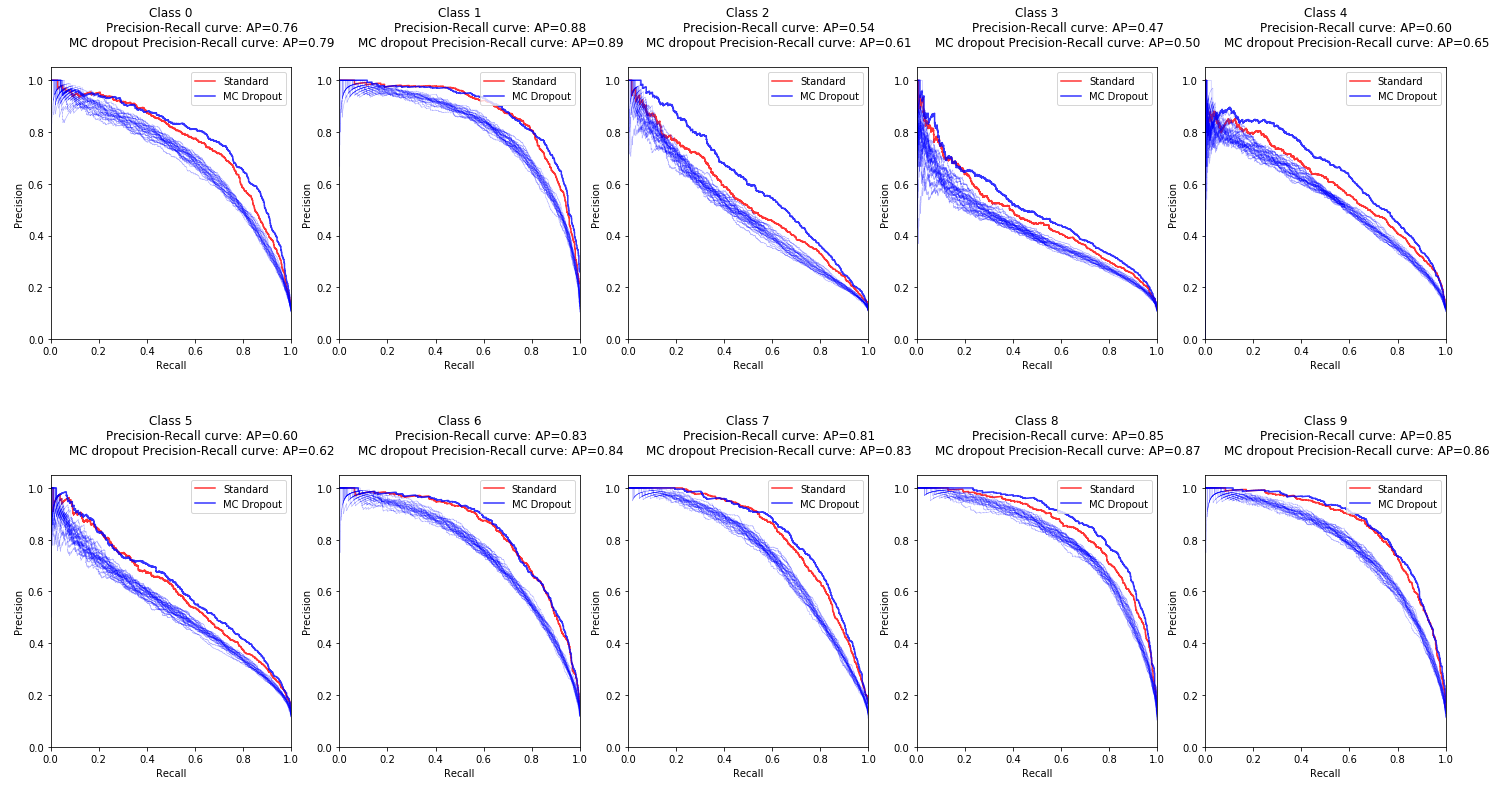

In [9]:
plt.figure()
plt.figure(figsize=(25, 20))
for i in range(n_targets):
    ax = plt.subplot(n_targets // 5 + 1, 5, i + 1)
    plt.subplots_adjust(hspace=0.5)
    
    recall, precision, recall_stoch, precision_stoch, average_precision, average_precision_stoch= get_pr_curves(i)
    
    plt.step(recall, precision, color='r', alpha=0.8,
         where='post', label = "Standard", linewidth=1.5)

    plt.step(recall_stoch, precision_stoch, color='b', alpha=0.8,
             where='post', label = "MC Dropout", linewidth=1.5)
    
    indicator_list = [1 if x == i else 0 for x in y_true]
    
    for j in range(monte_carlo_samples):
        
        dims = Yt_hat[j].shape[1:]
        yhat = Yt_hat[j].reshape(dims[0], dims[1])
        
        precision_stoch_j, recall_stoch_j, _ = precision_recall_curve(indicator_list,
                               yhat[:, i],
                               pos_label=1)
        plt.step(recall_stoch_j, precision_stoch_j, color='b', alpha=0.3,
             where='post', linewidth=0.5)


    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("""Class {0}
                Precision-Recall curve: AP={1:0.2f}
                MC dropout Precision-Recall curve: AP={2:0.2f}\n""".format(
              i, average_precision, average_precision_stoch), fontsize=12)
    plt.legend(loc='upper right')

    plt.savefig('class8.png')

plt.show()